In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA,AR,ARMA #先全引进来，说不定有用
from statsmodels.api import tsa
from random import randrange
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
df = pd.read_excel("Acc.xlsx")
len(df)

2440

In [3]:
df.head(3)

,date,week,address,count
0,2015-08-01,6,121,22628
1,2015-08-01,6,123,9056
2,2015-08-01,6,125,19838


# 取出单个车站，以每个车站的所有时间构成一个时间序列模型，也就是说通过循环构建20个时间序列。

In [84]:
subway = [155, 151, 125, 129, 121, 157, 147, 123, 159, 133, 135, 149, 131, 141, 127, 145, 139, 153, 143, 137]
frameList = [] #存放所有车站的dataframe的列表
for sw in subway:
    current_sw = df[(df['address']==sw)]
    current_sw.reset_index(drop=True,inplace=True)
    frameList.append(current_sw[["date",'count','address']])

In [85]:
len(frameList) #个数正常

20

# 首先研究单个车站的时间序列，随后组合成函数把其循环进去即可

In [26]:
frameList[0]

,date,count,address
0,2015-08-01,36421,155
1,2015-08-02,38261,155
2,2015-08-03,36255,155
3,2015-08-04,37117,155
4,2015-08-05,35162,155
...,...,...,...
117,2015-11-26,44187,155
118,2015-11-27,54067,155
119,2015-11-28,39718,155
120,2015-11-29,43049,155


# 一、选一个车站进行分析与测试

### 查看原时间序列是否平稳

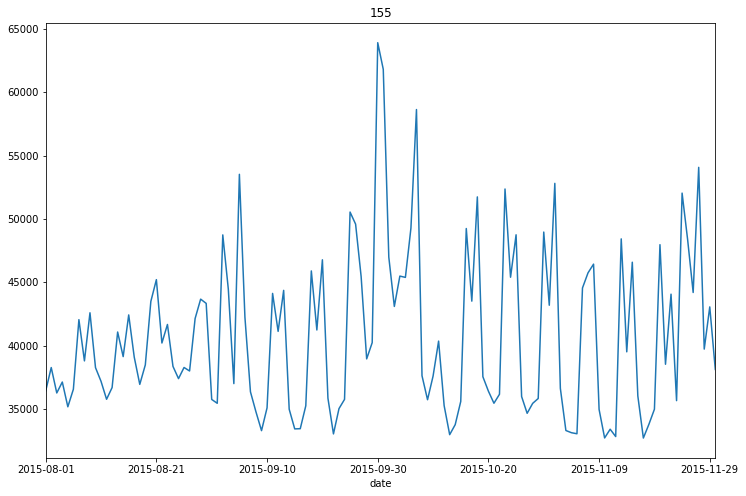

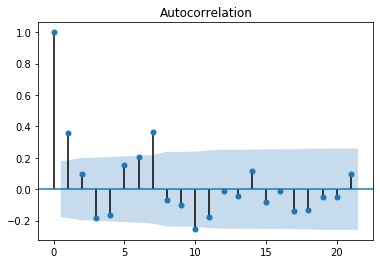

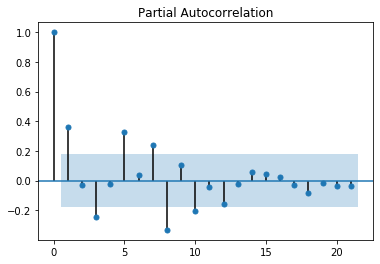

In [7]:
data = frameList[0]['count'] 
data.index = frameList[0]['date']

# data = data[:100].diff(1) #进行1阶拆分
# data = data.dropna()

plt.title(frameList[0]['address'][0])
data.plot(figsize=(12,8)) #可以看到存在明显的弱平稳序列,并不是明显的增长或者减低,直接使用即可，当然，如果为了保险可以进行一阶拆分。


#绘制自相关图
plot_acf(data).show()
plot_pacf(data).show()

In [10]:
len(data)

122

In [28]:
data[100:]

date
2015-11-09     597
2015-11-10     479
2015-11-11     534
2015-11-12     646
2015-11-13     623
2015-11-14     540
2015-11-15     498
2015-11-16     753
2015-11-17     507
2015-11-18     491
2015-11-19     615
2015-11-20    1126
2015-11-21     493
2015-11-22     481
2015-11-23     607
2015-11-24     744
2015-11-25     723
2015-11-26     721
2015-11-27    1085
2015-11-28    2859
2015-11-29    2975
2015-11-30     752
Name: count, dtype: int64

2013.59025798446 2042.2471300303291


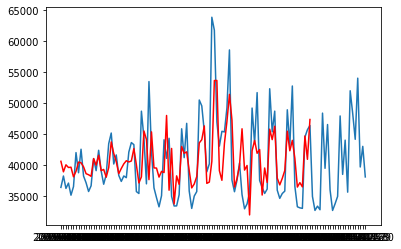

In [12]:
#直接训练模型看看
arma = ARMA(data[:100], order=(8,1,2)) #取100条作为训练集
rst = arma.fit(disp=False)
print(rst.aic, rst.bic)
plt.plot(data)
plt.plot(rst.fittedvalues, color='red')
plt.show()

In [14]:
#测试集上的预测:
start = pd.to_datetime('2015-11-09')
end =   pd.to_datetime('2015-11-30')
pred = rst.predict(start,end)
print(pred.head())

2015-11-09    36309.594590
2015-11-10    37335.562835
2015-11-11    37341.125723
2015-11-12    39928.412657
2015-11-13    45000.382081
Freq: D, dtype: float64


#### 把测试集和测试集预测结果拼在一起，方便计算MAE以及直接对比。

In [15]:
dftest = pd.concat([pred,data[100:]],axis=1)
dftest.columns=["true","predict"]
print(len(dftest))
dftest

22


,true,predict
2015-11-09,36309.594590,34954
2015-11-10,37335.562835,32703
2015-11-11,37341.125723,33392
2015-11-12,39928.412657,32812
2015-11-13,45000.382081,48420
2015-11-14,41842.293861,39502
2015-11-15,41886.302712,46577
2015-11-16,37365.534041,36019
2015-11-17,39505.507990,32696
2015-11-18,39948.554718,33778


In [16]:
# 计算测试集上的MAE
def get_MAE(testframe,predictframe,day_count,n_subway): #计算MAE
    abs_value_sum = 0
    for i in range(0,len(predictframe)):
        abs_value_sum += abs(predictframe[i]-testframe[i])
    return abs_value_sum/(day_count*n_subway)
MAE = get_MAE(dftest['true'],dftest['predict'],22,1)
MAE

4556.859127594242

In [17]:
# 模型预测七天
arma = ARMA(data, order=(8,1,2)) #取该车站全部数据作为训练集
rst = arma.fit(disp=False)
pred = rst.predict('2015-12-01','2015-12-07')
pred

2015-12-01    45398.938786
2015-12-02    42790.254388
2015-12-03    42095.994407
2015-12-04    45220.133663
2015-12-05    36580.113471
2015-12-06    42924.135591
2015-12-07    38564.201715
Freq: D, dtype: float64

# 二、选全部车站进行分析、建模以及完成任务

## 绘制acf和pacf图形寻找最佳参数

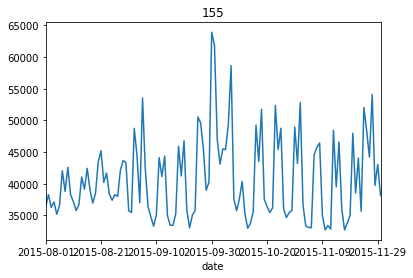

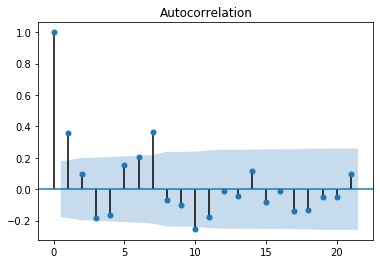

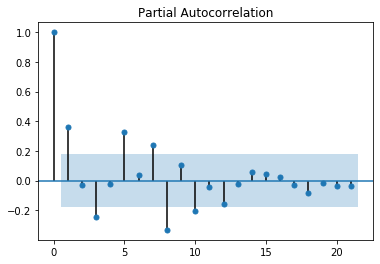

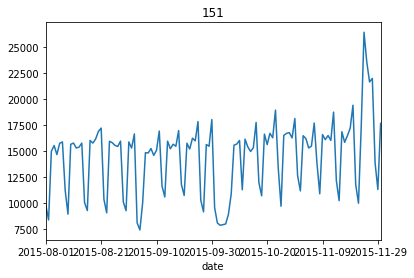

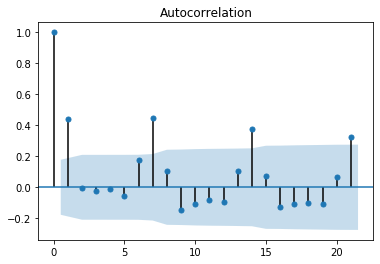

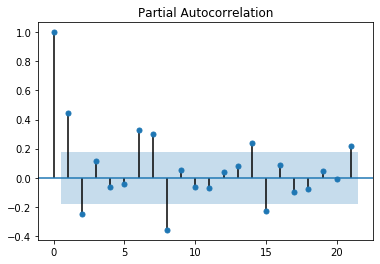

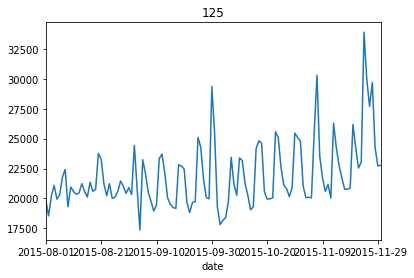

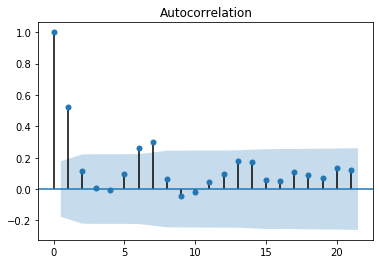

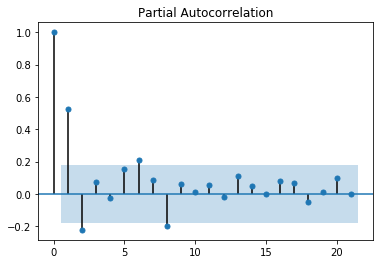

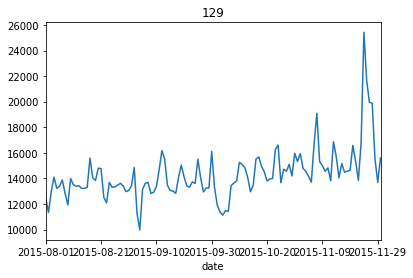

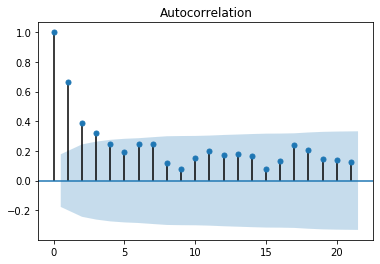

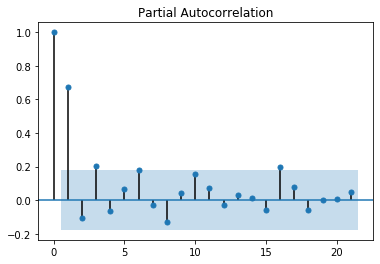

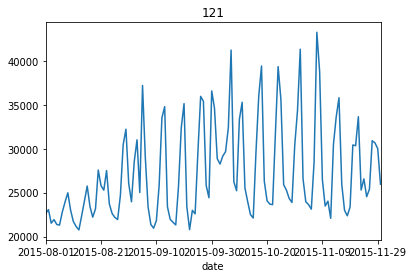

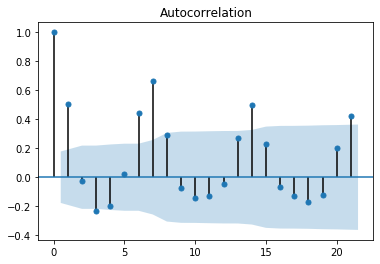

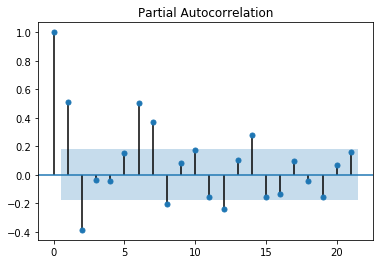

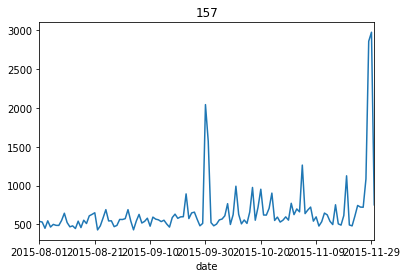

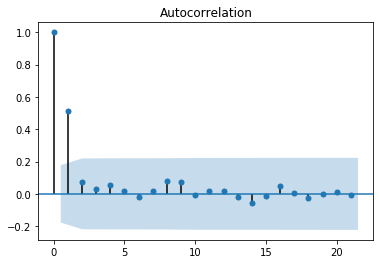

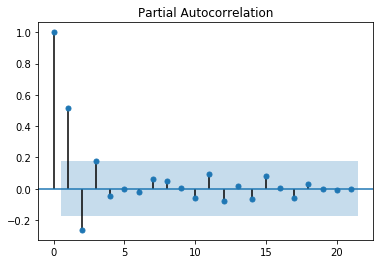

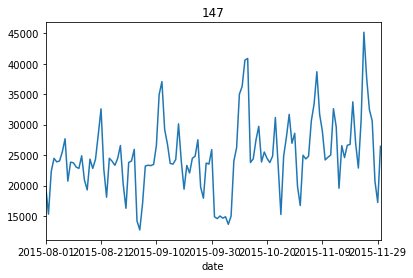

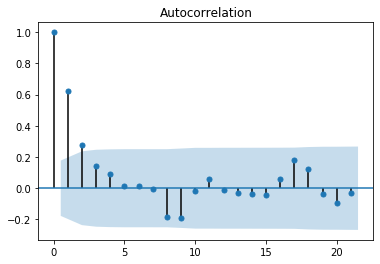

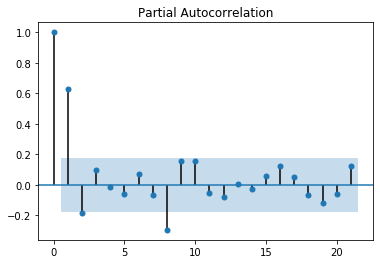

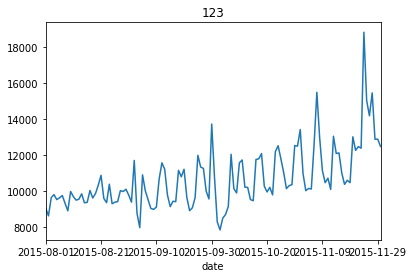

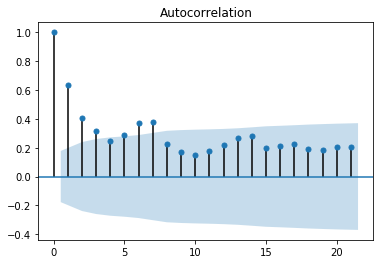

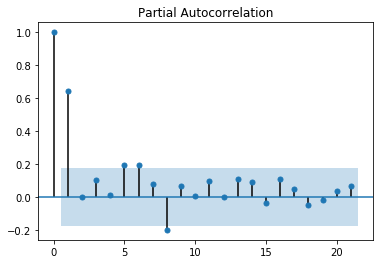

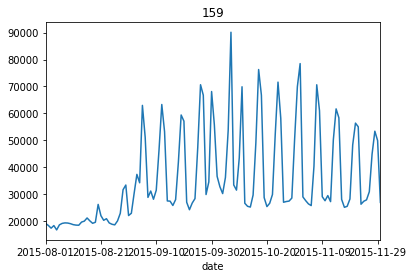

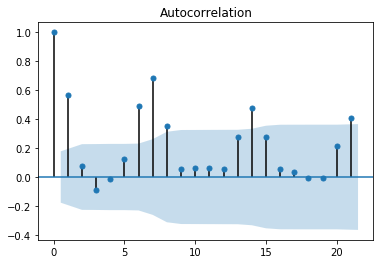

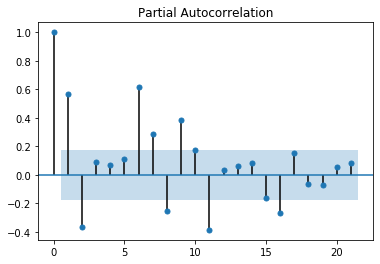

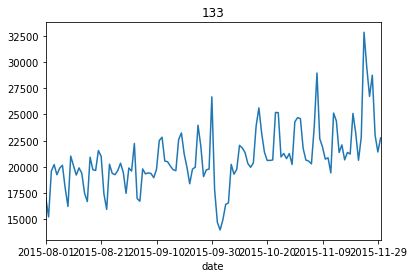

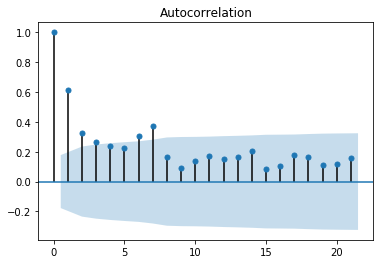

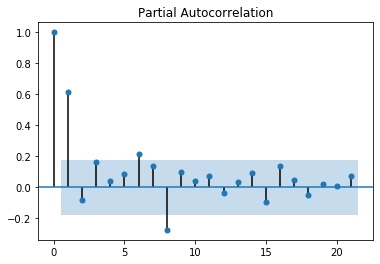

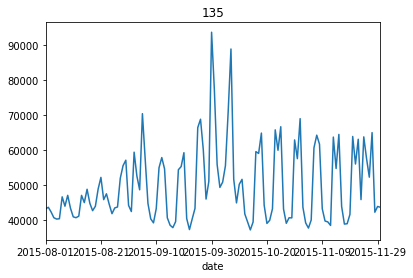

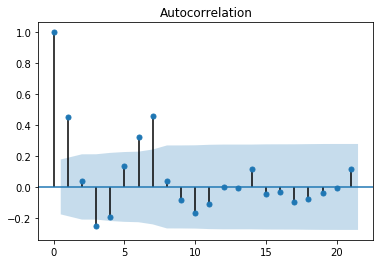

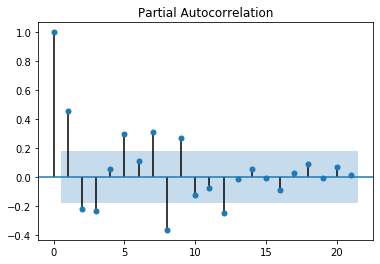

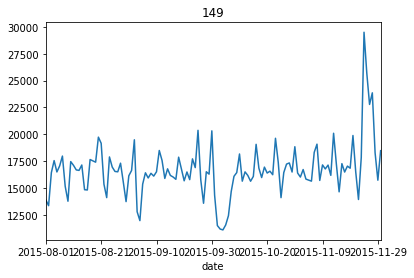

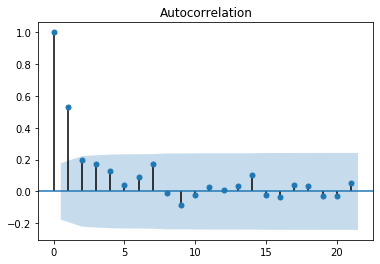

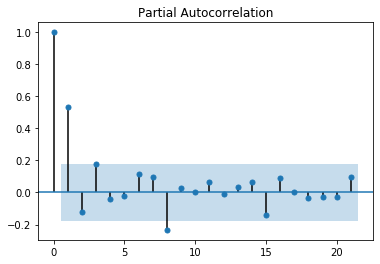

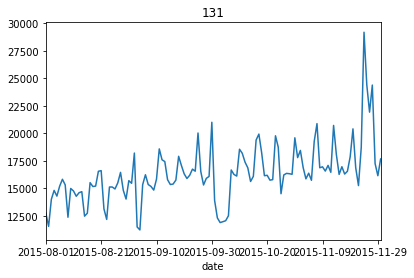

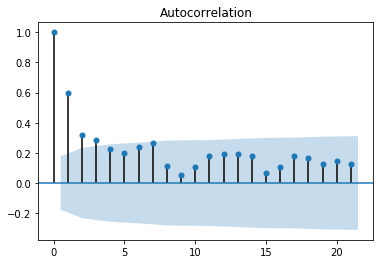

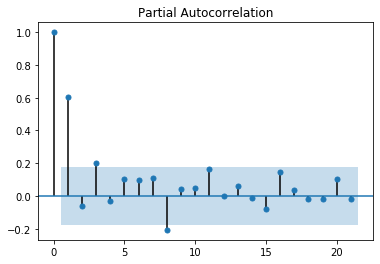

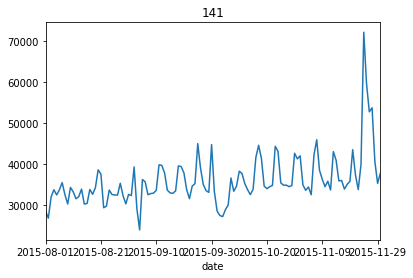

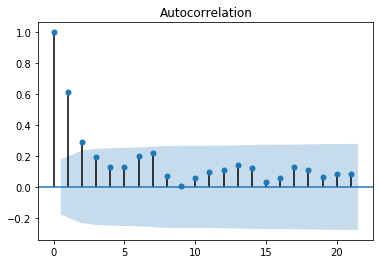

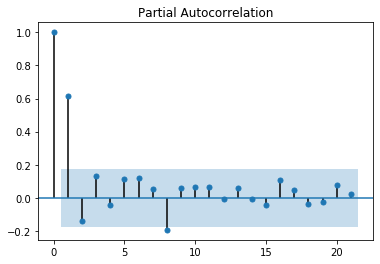

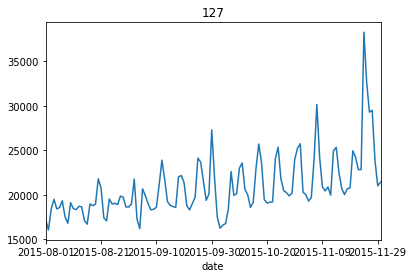

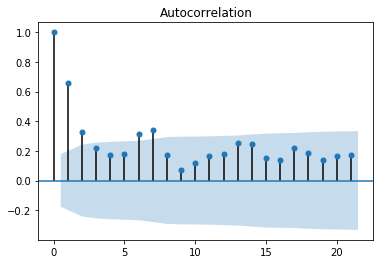

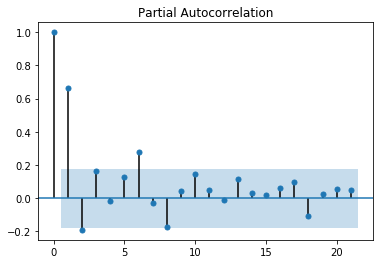

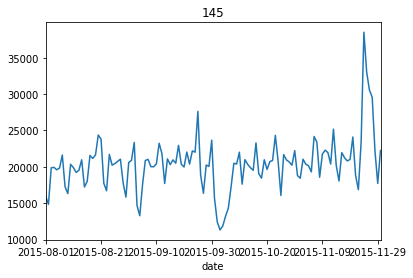

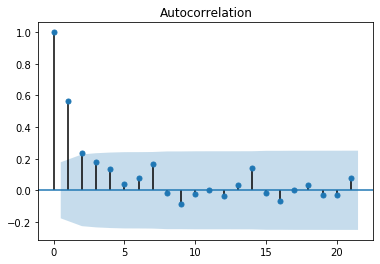

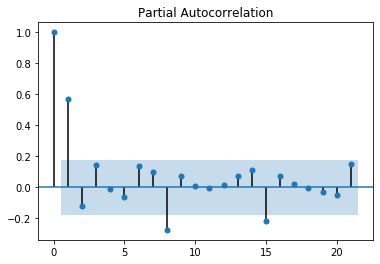

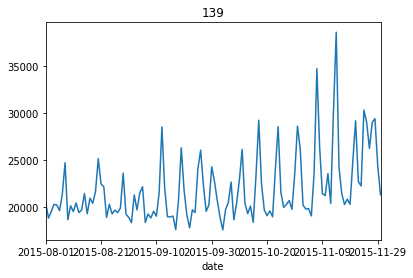

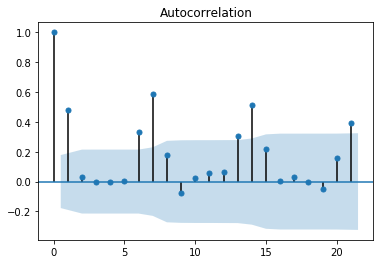

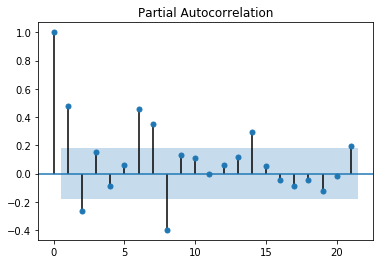

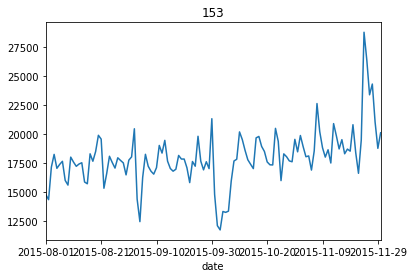

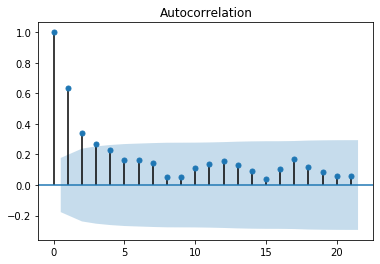

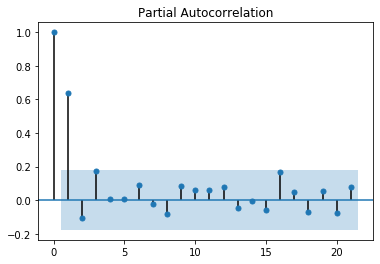

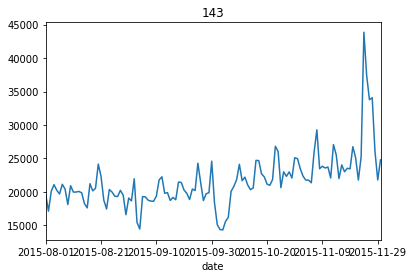

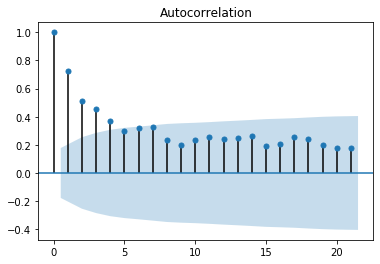

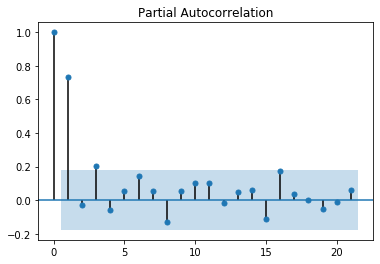

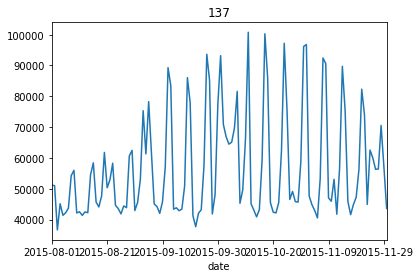

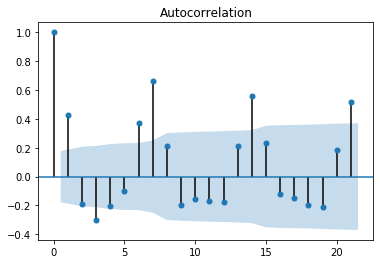

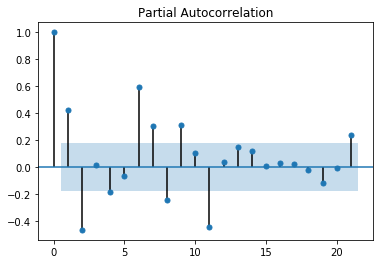

In [24]:
# # frameList
# #绘制多个车站 寻找p、d、q
def get_imformation(frameList):
    for i in range(0,20):
        
        data = frameList[i]['count']
        data.index = frameList[i]['date']
        plt.figure()
        data.plot()
        plt.title(frameList[i]['address'][0])
        #绘制自相关图
        plot_acf(data).show()
        plot_pacf(data).show()


get_imformation(frameList) 

# 如下为观察acf和pacf图之后各个车站模型选取出的参数

## 用原数据时的p、q:
* 155：12,2
* 151：2,5
* 125：3,3
* 129：9,7
* 121：2,3
* 157：3,5
* 147：5,4
* 123：10,2
* 159：4,12
* 133：9,4
* 135：2,4
* 149：5,5
* 131：9,4
* 141：9,4
* 127：10,4
* 145：5,4
* 139：2,11
* 153：9,4
* 143：9,2
* 137：5,3

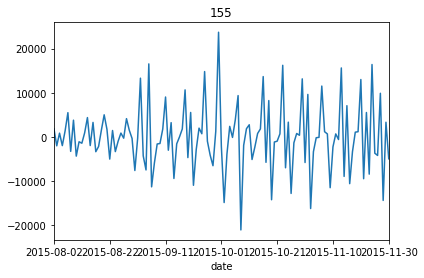

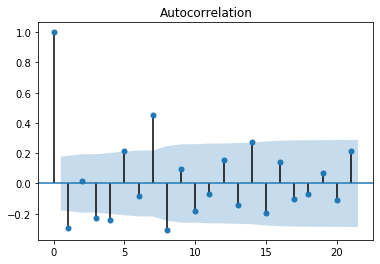

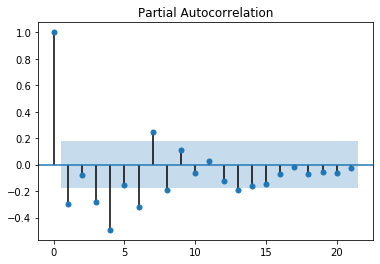

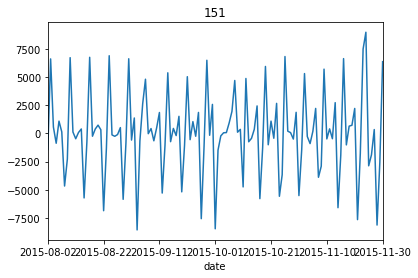

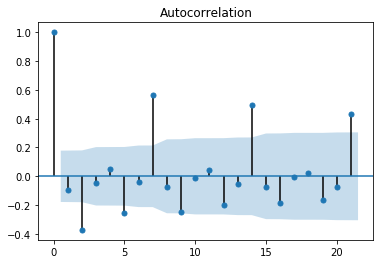

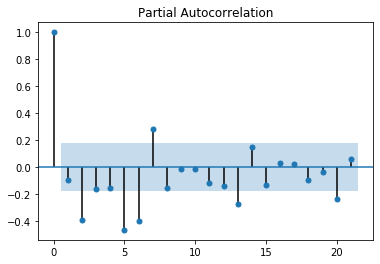

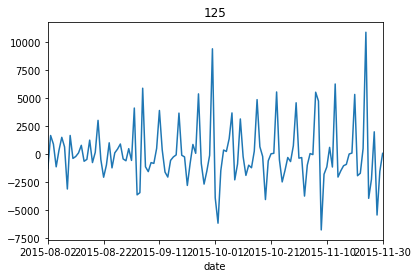

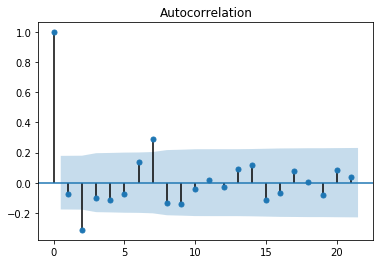

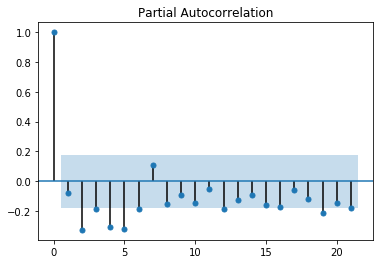

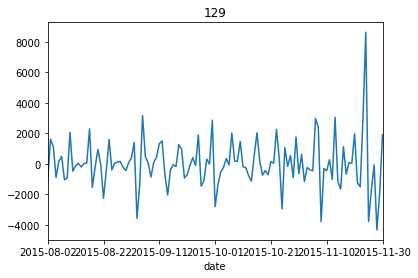

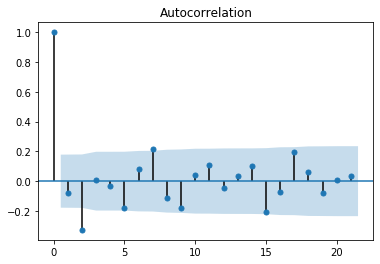

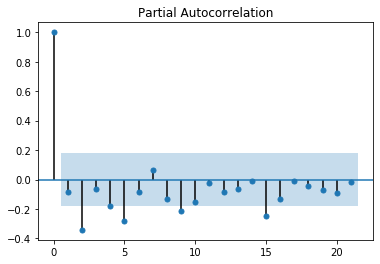

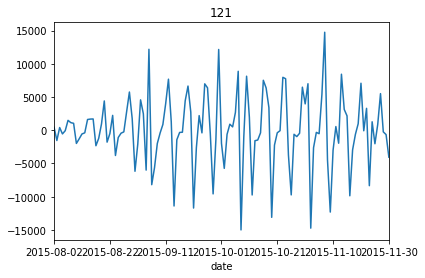

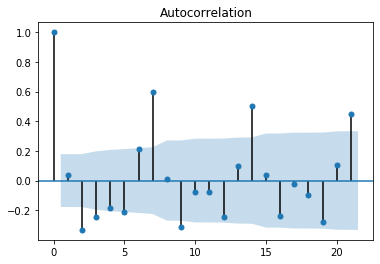

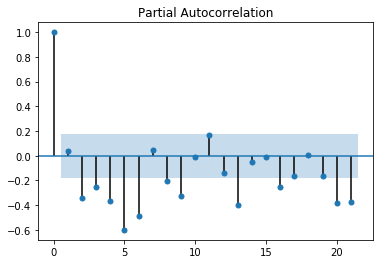

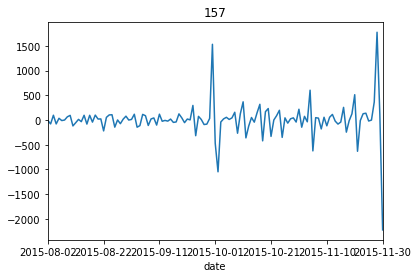

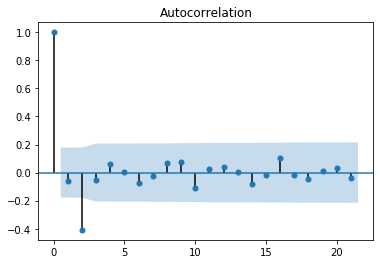

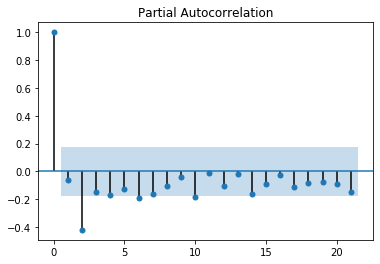

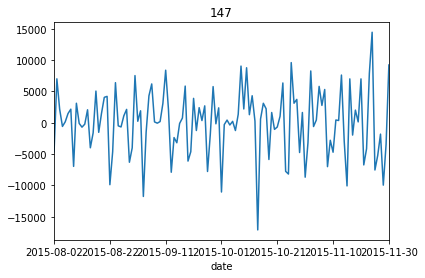

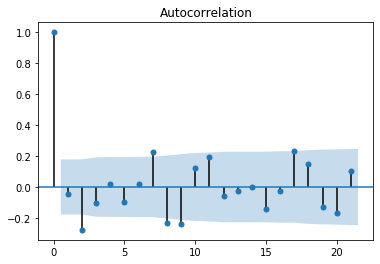

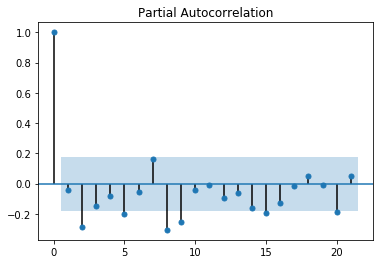

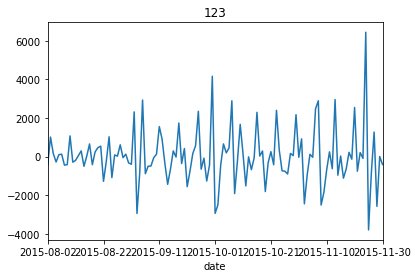

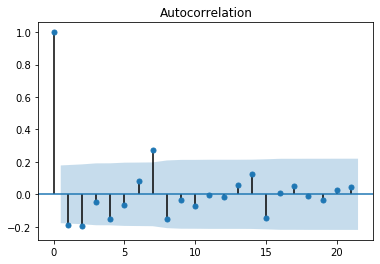

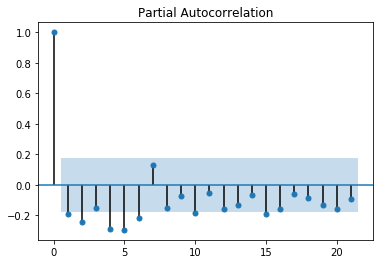

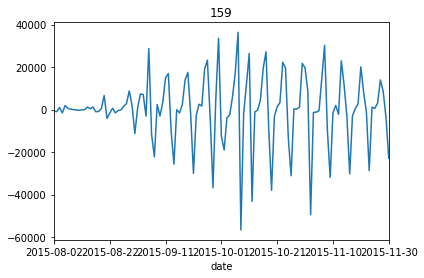

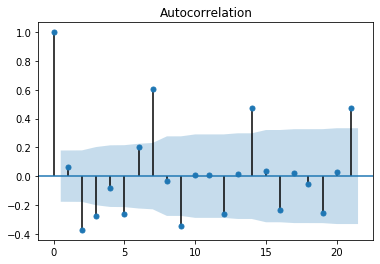

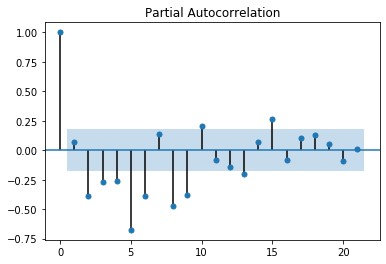

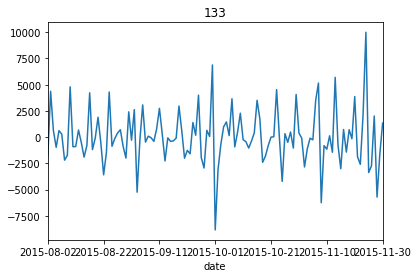

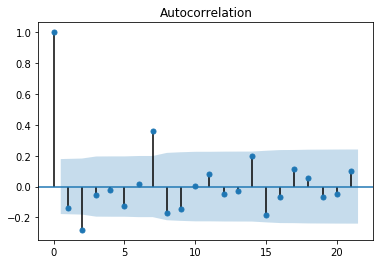

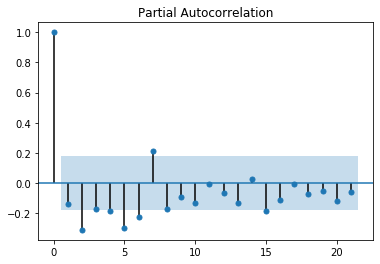

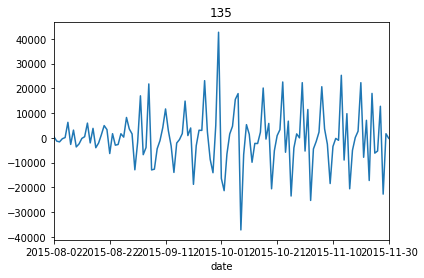

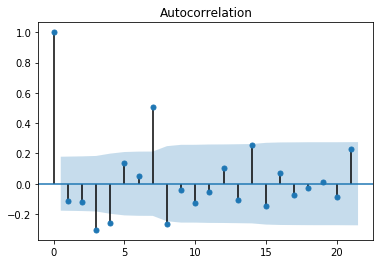

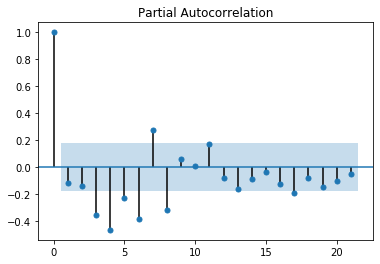

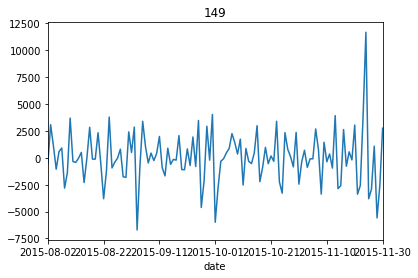

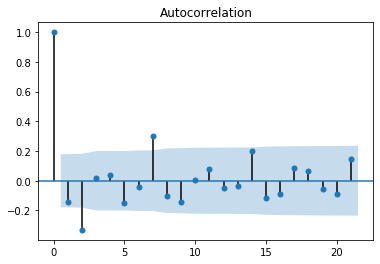

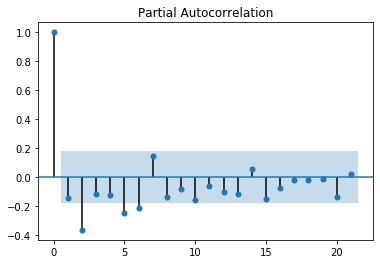

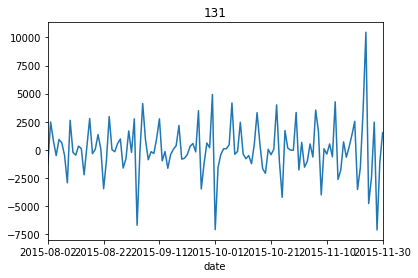

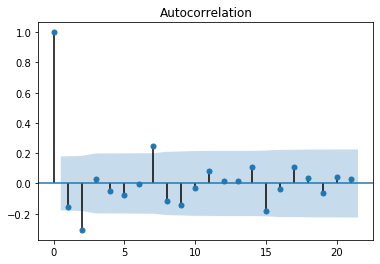

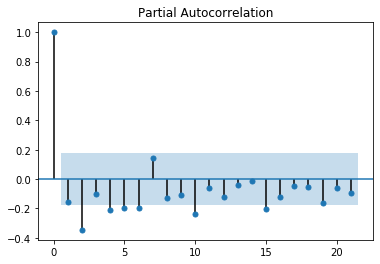

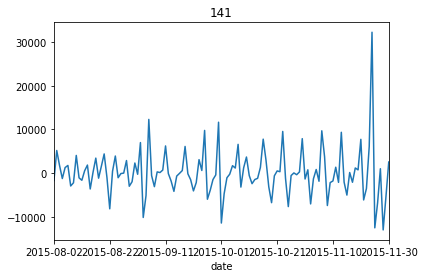

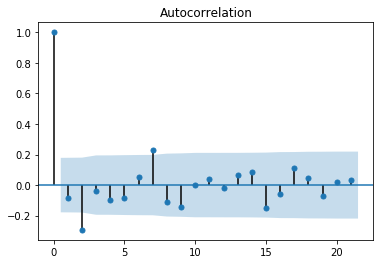

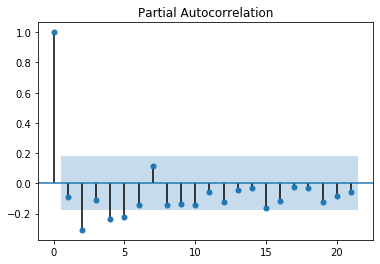

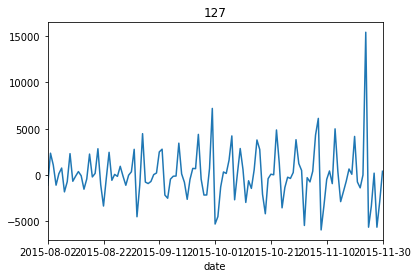

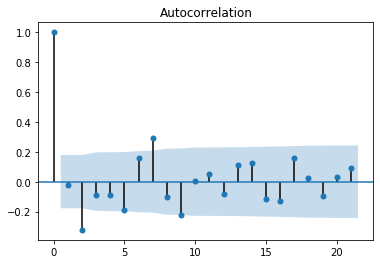

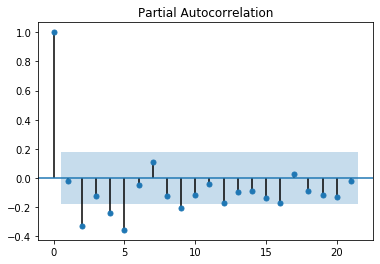

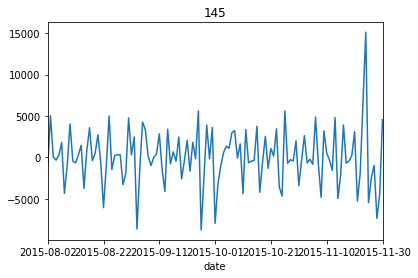

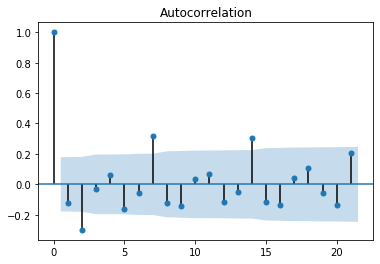

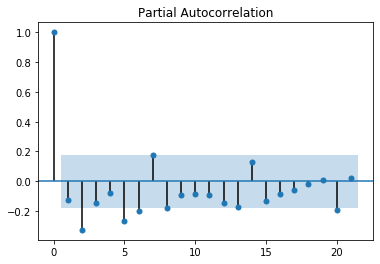

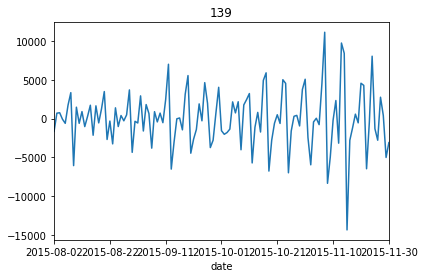

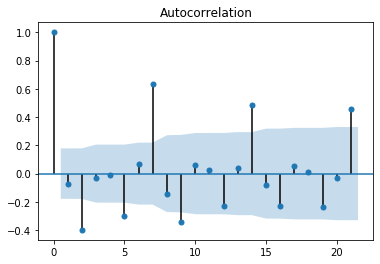

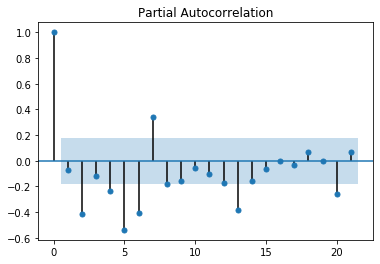

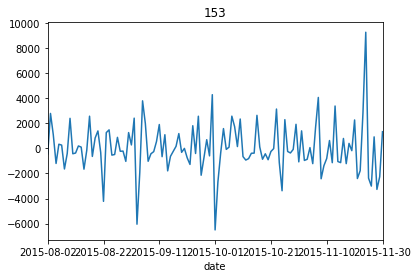

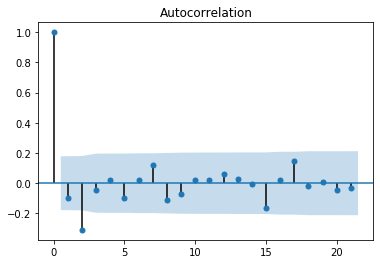

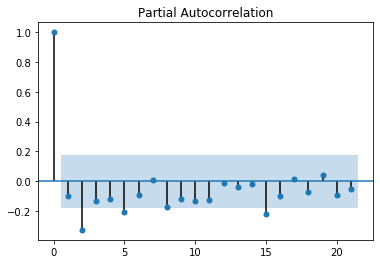

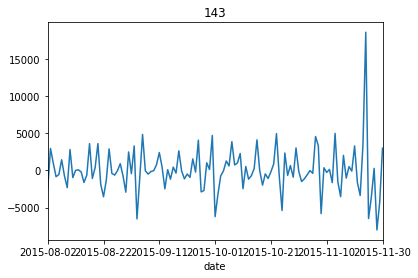

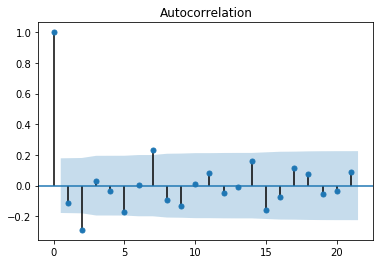

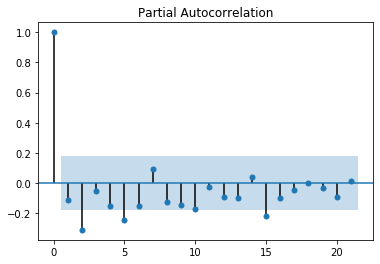

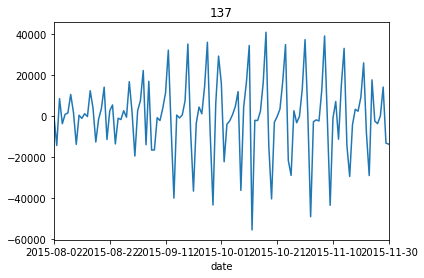

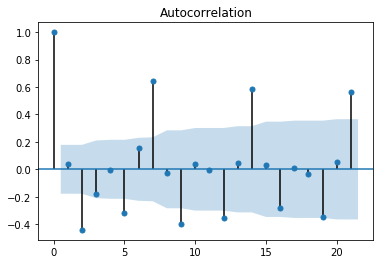

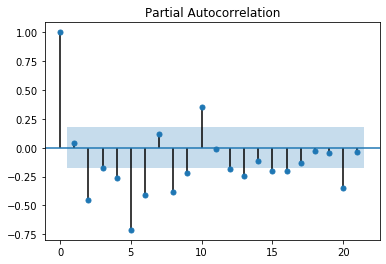

In [25]:
def get_imformation(frameList):
    for i in range(0,20):
        
        data = frameList[i]['count']
        data.index = frameList[i]['date']
        data = data.diff(1) #用一阶拆分,因为用原数据的时候并不是很友好
        data = data.dropna()
        plt.figure()
        data.plot()
        plt.title(frameList[i]['address'][0])
        #绘制自相关图
        plot_acf(data).show()
        plot_pacf(data).show()


get_imformation(frameList) 

# 如下为观察acf和pacf图之后各个车站模型选取出的参数

## 用一阶差分的数据时的p、q:
* 155：2,2
* 151：3,9
* 125：10,1
* 129：3,1
* 121：1,1
* 157：1,1
* 147：1,1
* 123：3,9
* 159：1,1
* 133：4,11
* 135：6,10
* 149：3,9
* 131：3,11
* 141：3,11
* 127：1,1
* 145：3,4
* 139：4,1
* 153：4,7
* 143：3,3
* 137：1,1

In [113]:
def get_MAE(testframe,predictframe,day_count,n_subway): #计算MAE
    abs_value_sum = 0
    for i in range(0,len(predictframe)):
        abs_value_sum += abs(predictframe[i]-testframe[i])
    return abs_value_sum/(day_count*n_subway)

In [152]:
def predict(frameList):
    dict_parameter = {155:(12,2),151:(2,5),125:(3,3),129:(9,7),121:(2,3),157:(3,5),147:(5,4),123:(10,2),159:(4,12),133:(9,4),
                 135:(2,4),149:(5,5),131:(9,4),141:(9,4),127:(8,4),145:(5,4),139:(2,11),153:(9,4),143:(9,2),137:(5,13)}
    MAE=0
    predictFrame = pd.DataFrame(columns=['date','predict','address'])
    for i in range(0,20):
        datas = frameList[i]
        data = frameList[i]['count'][:100]
        data.index = frameList[i]['date'][:100]
        pq=dict_parameter[frameList[i]['address'][0]]
        arma = ARMA(data[:100], order=(pq[0],1,pq[1])) #取该车站部分数据作为训练集
        rst = arma.fit(disp=False)
        pred = rst.predict('2015-11-09','2015-11-30')
        pred = pred.reset_index()
        pred.columns=['date','predictCount']
        for j in range(0,len(pred)):
            if type(pred['date'][j]) != str:
                pred['date'][j] = pred['date'][j].strftime('%Y-%m-%d')
        testcountframe = frameList[i]['count'][100:]
        testcountframe = testcountframe.reset_index(drop=True)
        addressframe = frameList[i]["address"][100:]
        addressframe = addressframe.reset_index(drop=True)
        y=pd.concat([testcountframe,pred,addressframe],axis=1)
        mae = get_MAE(y['count'],y['predictCount'],22,1)
        MAE += mae
        print(frameList[i]['address'][0],'车站MAE:',mae)
#         ------------------------------------------------------- 坑
        datap = frameList[i]['count'][:]
        datap.index = frameList[i]['date'][:]
        datap = datap.dropna()
        armap = ARMA(datap, order=(pq[0],1,pq[1])) #取该车站全部数据作为训练集
        rstp = armap.fit(disp=False)
        predictf = rstp.predict('2015-12-01','2015-12-07')
        predictf = predictf.reset_index()
        predictf.columns=['date','predict']
        for k in range(0,len(predictf)):
            if type(predictf['date'][k]) != str:
                predictf['date'][k] = predictf['date'][k].strftime('%Y-%m-%d')
        address = frameList[i]["address"][:7]
        address = address.reset_index(drop=True)
        frame = pd.concat([predictf,address],axis=1)
        predictFrame = pd.concat([predictFrame,frame],axis=0)
        predictFrame = predictFrame.reset_index(drop=True)
        
    print('\n平均绝对误差:',MAE/20)
    return predictFrame
    
s = predict(frameList)

155 车站MAE: 4544.7172612971835
151 车站MAE: 4116.911405651782
125 车站MAE: 3215.6875882800496
129 车站MAE: 2030.6716507620547
121 车站MAE: 3301.611257568429
157 车站MAE: 331.61054524036894
147 车站MAE: 5685.1536441530925
123 车站MAE: 1632.3119029768316
159 车站MAE: 17818.386601422797
133 车站MAE: 2908.596734870854
135 车站MAE: 9150.886291530576
149 车站MAE: 2801.843209957689
131 车站MAE: 2339.478963786615
141 车站MAE: 6341.953067752256
127 车站MAE: 3401.407098229292
145 车站MAE: 4268.768093146887
139 车站MAE: 4511.845851992868
153 车站MAE: 2768.9979997567466
143 车站MAE: 4862.874143793491
137 车站MAE: 10194.23039190346

平均绝对误差: 4811.397185203667


# 可以看到MAE值非常高，所以选择另外的模型。

In [154]:
s.to_excel("三个模型的预测数据对比/七天预测对比/time.xlsx",index=None)